In [3]:
from numpy.random import seed
seed(1)
seed

import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import median_filter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.signal import medfilt
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint
import keras
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Data loading
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')

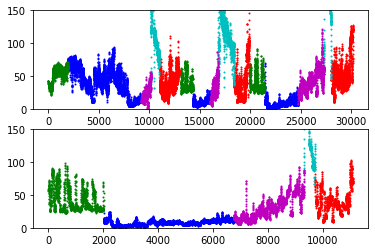

In [5]:
# Petrophysics-based zonation for both training and test set based on GR, ZDEN, CNC. Compared to test set,
# we found the training set showed similar spatial patterns, to take advantage of the spatial correlation
# we performed inter-well correlation. Per-zone estimation has been proved to be a good preprocessing method for well-log
# interpretation (Pan et al., in press; Pan et al., 2019)
df1['zone']=0
df1['zone'][13100:14297]=1;
df1['zone'][19890:21410]=1;
df1['zone'][:1925]=1;
#df1['zone'][1925:7000] no corresponding zone
#df1['zone'][7000:9210] DTS missing



df1['zone'][28022:]=2;
df1['zone'][18400:19888]=2;
df1['zone'][10993:12997]=2;

df1['zone'][27276:28022]=3;
df1['zone'][16823:18400]=3;
df1['zone'][10142:10993]=3;

df1['zone'][24753:27276]=4;
df1['zone'][16037:16823]=4;
df1['zone'][9210:10142]=4;

df2['zone']=0
df2['zone'][:2010]=1
df2['zone'][6749:9316]=4
df2['zone'][9316:9710]=3
df2['zone'][9710:]=2

co=['b','g','r','c','m','y']

# Figures show the patterns of gamma ray for different zones
for i in range(6):
    plt.subplot(2, 1, 1)
    plt.scatter(df1.index[df1.zone.values==i],df1.GR.values[df1.zone.values==i],s=1,color=co[i])
    plt.ylim([0,150])
    plt.subplot(2, 1, 2)
    plt.scatter(df2.index[df2.zone.values==i],df2.GR.values[df2.zone.values==i],s=1,color=co[i])
    plt.ylim([0,150])

In [6]:
# Delete points where data are missing 
df1=df1[['CNC','GR','ZDEN','HRD','DTC','DTS','zone','CAL','HRM','PE']]
df1.replace(['-999', -999], np.nan, inplace=True)
df1.dropna(axis=0, inplace=True)
df2=df2[['CNC','GR','ZDEN','HRD','zone','CAL','HRM','PE']]
df2.replace(['-999', -999], np.nan, inplace=True)
df2.dropna(axis=0, inplace=True)

DTC2=np.zeros(df2.shape[0])# array for saving predictions
DTS2=np.zeros(df2.shape[0])

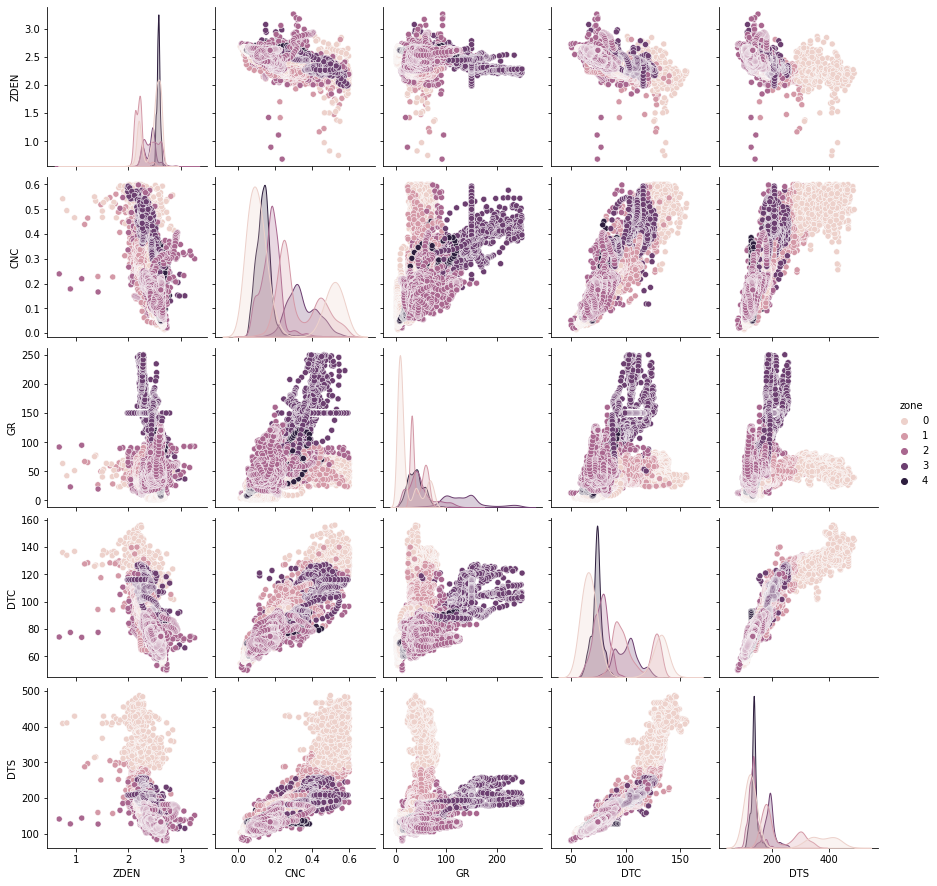

In [7]:
df_plot=df1.copy()
df_plot['CNC'][df_plot['CNC']>0.6]=np.nan
df_plot['CNC'][df_plot['CNC']<-0.15]=np.nan
df_plot['GR'][df_plot['GR']>250]=150
df_plot.dropna(axis=0, inplace=True)
g=sb.pairplot(df_plot[['ZDEN', 'CNC','GR','DTC','DTS','zone']],hue='zone')

In [8]:
#Perform logrithmic transformation to resistivity logs to avoid large weight on resisitivity logs
df1['HRD_log']=np.log(df1.HRD.values)
df2['HRD_log']=np.log(df2.HRD.values)
df1['HRM_log']=np.log(df1.HRM.values)
df2['HRM_log']=np.log(df2.HRM.values)

# Calculate the gradients of input logs
# Interpolated well logs should have similar gradients
for i in df1.keys():
    df1[i+'grad']=np.gradient(df1[i].values)
for i in df2.keys():
    df2[i+'grad']=np.gradient(df2[i].values)
#Observe the patterns of logs

In [10]:
for iiii in [0,1,2,3,4]:
    df=df1[df1.zone.values==iiii].copy()
    df_test=df2[df2.zone.values==iiii].copy()


    x=df[['CNC','GR','ZDEN','HRD_log','HRM_log','PE','CNCgrad','GRgrad','ZDENgrad']].copy()
    
    # To remove the noise, preserve the relative magnitude of the signals and given the fact that the vertical resolution of sonic logs are 
    #not as high as other logs, we use median filter to preprocessing the input features.
    for i in x.keys():
        x[i]=median_filter(df[i].values,21,mode='nearest')
    y=df[['DTC','DTS']].copy()
    
    # Minmax scaling is used to constrain the range of the output.
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_train = scaler_X.fit_transform(x.values)
    x_train=np.concatenate([x_train[1:-1],x_train[0:-2],x_train[2:]],axis=-1)    
    y_train = scaler_y.fit_transform(y.values)
    y_train = y_train[1:-1]
    
    #same operations are applied to test set.
    x_test=df_test[['CNC','GR','ZDEN','HRD_log','HRM_log','PE','CNCgrad','GRgrad','ZDENgrad']].values#,'RM_log'
    for i in range(x_test.shape[1]):
        x_test[:,i]=median_filter(x_test[:,i],21,mode='nearest')
    x_test=scaler_X.transform(x_test)
    # To account for spatial correlations, we add window to take into account the effects of logs at adjacent depths.
    # add window
    x_test=np.concatenate([x_test[1:-1],x_test[0:-2],x_test[2:]],axis=-1) 

    # A simple fully connected neural network is used for prediction
    model_1 = Sequential([
        Dense(24, activation='relu', input_shape=(27,)),
        Dense(12, activation='relu'),
        Dense(2,activation='sigmoid'),
    ])
 

    
    model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])
    np.random.seed(1)
    
    
    save_model_name = str(iiii)+'_Model'
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='loss', mode = 'min', save_best_only=True, verbose=1)
    hist_1 = model_1.fit(x_train, y_train, batch_size=10, epochs=9, callbacks=[model_checkpoint])
    
    y_test2=model_1.predict(x_test)
    y_test2=scaler_y.inverse_transform(y_test2)
    y_test2=np.concatenate([y_test2[0:1,:],y_test2,y_test2[-1:,:]],axis=0)
    # save the prediction
    DTC2[df2.zone.values==iiii]=y_test2[:,0]
    DTS2[df2.zone.values==iiii]=y_test2[:,1]

Epoch 1/9
720/729 [============================>.] - ETA: 0s - loss: 0.0088 - mae: 0.0512
Epoch 1: loss improved from inf to 0.00872, saving model to 0_Model
729/729 [==============================] - 4s 3ms/step - loss: 0.0087 - mae: 0.0509
Epoch 2/9
716/729 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0225
Epoch 2: loss improved from 0.00872 to 0.00120, saving model to 0_Model
729/729 [==============================] - 2s 3ms/step - loss: 0.0012 - mae: 0.0225
Epoch 3/9
720/729 [============================>.] - ETA: 0s - loss: 0.0010 - mae: 0.0208
Epoch 3: loss improved from 0.00120 to 0.00101, saving model to 0_Model
729/729 [==============================] - 2s 3ms/step - loss: 0.0010 - mae: 0.0208
Epoch 4/9
721/729 [============================>.] - ETA: 0s - loss: 8.5023e-04 - mae: 0.0185
Epoch 4: loss improved from 0.00101 to 0.00085, saving model to 0_Model
729/729 [==============================] - 2s 3ms/step - loss: 8.4797e-04 - mae: 0.0185
Epoch 5/9
72

In [11]:
df3 = pd.read_csv('real_result_20perc.csv')
dtc=-999*np.ones(len(df3))
dts=-999*np.ones(len(df3))
for i in range(2217):
    flag = (abs(df2['GR']-df3['GR'][i])<0.001) * \
    (abs(df2['ZDEN']-df3['ZDEN'][i])<0.001) * \
    (abs(df2['CNC']-df3['CNC'][i])<0.005) * \
    (abs(df2['PE']-df3['PE'][i])<0.001)
    dts[i] = DTS2[flag]
    dtc[i] = DTC2[flag]

RMSE of test data (#1 DTC): 4.77
RMSE of test data (#2 DTS): 19.29
Overall RMSE = 14.05


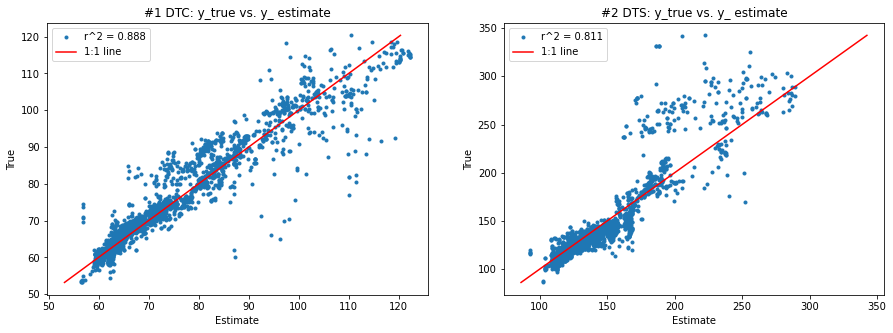

In [12]:
# Compute estimations:
y_20test_ = np.concatenate([dtc.reshape(dtc.shape[0],1), dts.reshape(dts.shape[0],1)], axis=1) 
y_20true_ = df3[['DTC','DTS']].values

# Plot results:
plt.figure(figsize=(15,5))
i = 0
plt.subplot(1,2,i+1)
plt.plot(y_20test_[:,i], y_20true_[:,i], '.', label = 'r^2 = %.3f' % (r2_score(y_20true_[:,i], y_20test_[:,i])))
plt.plot([y_20true_[:,i].min(),y_20true_[:,i].max()],[y_20true_[:,i].min(),y_20true_[:,i].max()], 'r', label = '1:1 line')
plt.title('#1 DTC: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()
i += 1
plt.subplot(1,2,i+1)
plt.plot(y_20test_[:,i], y_20true_[:,i], '.', label = 'r^2 = %.3f' % (r2_score(y_20true_[:,i], y_20test_[:,i])))
plt.plot([y_20true_[:,i].min(),y_20true_[:,i].max()],[y_20true_[:,i].min(),y_20true_[:,i].max()], 'r', label = '1:1 line')
plt.title('#2 DTS: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()

MSE_0 = mean_squared_error(y_20true_[:,0], y_20test_[:,0]);
RMSE_0 = np.sqrt(mean_squared_error(y_20true_[:,0], y_20test_[:,0]));
MSE_1 = mean_squared_error(y_20true_[:,1], y_20test_[:,1]);
RMSE_1 = np.sqrt(mean_squared_error(y_20true_[:,1], y_20test_[:,1]));
print('RMSE of test data (#1 DTC): %.2f' %(RMSE_0))
print('RMSE of test data (#2 DTS): %.2f' %(RMSE_1))
print('Overall RMSE = %.2f' %np.sqrt((MSE_0+MSE_1)/2))

In [15]:
output_result = pd.DataFrame({'DTC':DTC2, 'DTS':DTS2})
output_result.head()

,DTC,DTS
0,104.284210,203.330627
1,104.284210,203.330627
2,104.739014,203.374863
3,105.702530,206.137161
4,106.315956,209.373627


In [16]:
#output_result.to_csv('output.csv', index=False)
output_result.to_csv('output.csv', index=False)

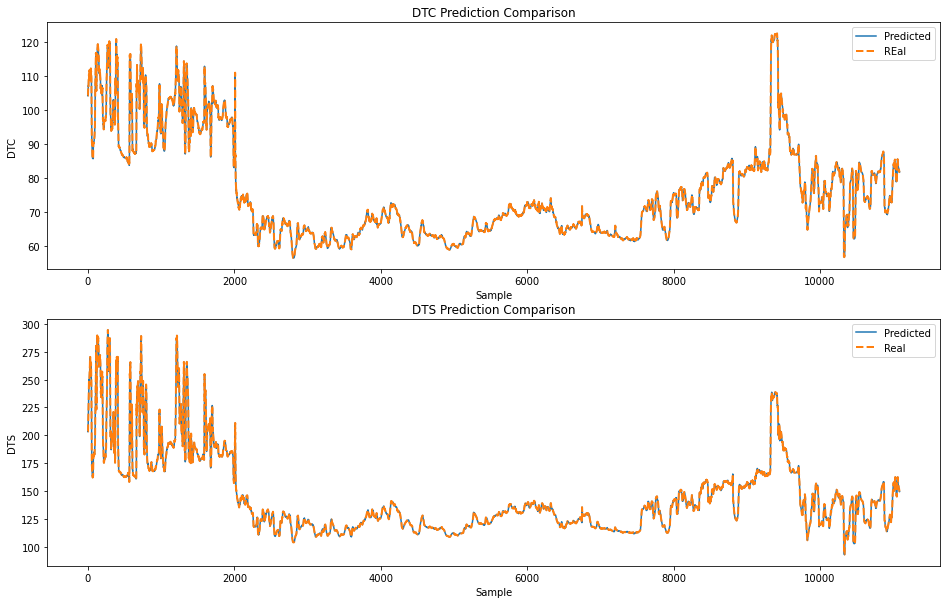

In [18]:
output=pd.read_csv('output.csv')
plt.subplots(nrows=1, ncols=2, figsize=(16,10))
plt.subplot(2, 1, 1)
plt.plot(DTC2)
plt.plot(output['DTC'].values,'--',linewidth=2)
plt.legend(['Predicted','REal'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(2, 1, 2)
plt.plot(DTS2)
plt.plot(output['DTS'].values,'--',linewidth=2)
plt.legend(['Predicted','Real'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()